In [13]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.impute import SimpleImputer  
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Read the math placement data from the Excel file
df_math_placement = pd.read_excel('math_placement2024-02-29.xlsx')

# Read the edready raw scores data from the CSV file
df_ed_ready = pd.read_csv('edready_raw_scores.csv')

# Load the file of incoming students
#incoming_students = pd.read_csv('incoming_students.csv')will need to change to correct file name


In [15]:

df_cleaned = df_math_placement.copy()

# Define the mapping of grades to grade categories
grade_mapping = {
    "A": "Successful", "B": "Successful", "B+": "Successful",
    "A-": "Successful", "B*": "Successful", "A*": "Successful",
    "B+*": "Successful", "W": "Unsuccessful", "C-": "Unsuccessful",
    "F": "Unsuccessful", "B-": "Successful", "C+": "Unsuccessful",
    "D": "Unsuccessful", "D*": "Unsuccessful", "C": "Unsuccessful",
    "W*": "Unsuccessful", "P*": "Successful", "C+*": "Unsuccessful",
    "F*": "Unsuccessful", "D+": "Unsuccessful", "P": "Successful",
    "C*": "Unsuccessful", "A-*": "Successful", "I": "Unsuccessful",
    "AU": "Ignore", "B-*": "Successful", "D-": "Unsuccessful",
    "NR": "Ignore", "C-*": "Unsuccessful", "I*": "Unsuccessful",
    "NR*": "Ignore"
}

# Map the grades to their categories and append as a new column
df_cleaned['grade_category'] = df_cleaned['grade'].map(grade_mapping)


# Define base courses and adjust the list based on 'campus_code'
base_courses = ['088', '216Q', '132', '161Q', '151Q', '165Q', '171Q']
courses_to_check = ['105Q', '090', '121Q']

for course in courses_to_check:
    if df_cleaned[(df_cleaned['campus_code'] != 'ZGC') & (df_cleaned['course_number'] == course)].shape[0] > 0:
        base_courses.append(course)

# Define course combinations
course_combinations = {
    'Combo1': ('005', '105Q'),
    'Combo2': ('063', '090'),
    'Combo3': ('021', '121Q')
}

# Map courses and combinations to levels
course_levels = {
    '088': 100,
    'Combo2': 100,  # ('063', '090')
    'Combo1': 150,  # ('005', '105Q')
    '090': 150,
    'Combo3': 250,  # ('021', '121Q')
    '105Q': 290,
    '216Q': 300,
    '132': 300,
    '121Q': 300,
    '161Q': 400,
    '151Q': 400,
    '165Q': 500,
    '171Q': 500
}

# Function to determine course level based on the course number or combination
def determine_course_level(course_number, campus_code):
    # Handle special cases for '105Q', '090', '121Q' based on 'campus_code'
    if course_number in ['105Q', '090', '121Q'] and campus_code == 'ZGC':
        # Exclude these courses for ZGC campus
        return None
    for combo_name, combo_courses in course_combinations.items():
        if course_number in combo_courses:
            # Return the level for the course combination
            return course_levels[combo_name]
    # Return the level for individual courses
    return course_levels.get(course_number)

# Apply the function to each row in df_cleaned to create a new 'course_level' column
df_cleaned['course_level'] = df_cleaned.apply(lambda row: determine_course_level(row['course_number'], row['campus_code']), axis=1)

# Make sure the column names match in both dataframes before merging
df_cleaned.rename(columns={'pidm': 'PIDM'}, inplace=True)

# Create a new column to store the PIDM, course number, and term as a single string
df_cleaned['PIDM_course_number_term'] = df_cleaned['PIDM'].astype(str) + '_' + df_cleaned['course_number'].astype(str) + '_' + df_cleaned['term'].astype(str)

# Remove duplicates based on the new column
df_cleaned = df_cleaned.drop_duplicates(subset='PIDM_course_number_term')

# Display the cleaned and imputed dataframe
df_cleaned.head()





,Unnamed: 0,PIDM,term_code,gid,admit_term,degree.x,major_code,college.x,major.x,stu_type,...,section_number,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category,course_level,PIDM_course_number_term
0,1,41845,202250,-37474,202250.0,Master of Science,MATO,College of Letters & Science,Mathematics,N,...,801,M,L,GR,3,RW,A,Successful,NaN,41845_533_202370
1,2,41845,202250,-37474,202250.0,Master of Science,MATO,College of Letters & Science,Mathematics,N,...,801,M,L,GR,3,RE,A,Successful,NaN,41845_518_202250
2,3,41845,202250,-37474,202250.0,Master of Science,MATO,College of Letters & Science,Mathematics,N,...,1,M,L,GR,3,RE,B,Successful,NaN,41845_524_202350
3,4,41845,202250,-37474,202250.0,Master of Science,MATO,College of Letters & Science,Mathematics,N,...,1,M,L,GR,3,RE,A,Successful,NaN,41845_520_202250
4,5,41845,202250,-37474,202250.0,Master of Science,MATO,College of Letters & Science,Mathematics,N,...,801,M,L,GR,3,RE,A,Successful,NaN,41845_577_202330


In [16]:

# Convert 'term' to a numeric type to ensure correct sorting
df_cleaned['term'] = pd.to_numeric(df_cleaned['term'])

# Find the oldest term for each PIDM
oldest_terms = df_cleaned.groupby('PIDM')['term'].min().reset_index()

# Merge the oldest terms back to the original DataFrame to filter records
df_oldest = pd.merge(df_cleaned, oldest_terms, on=['PIDM', 'term'], how='inner')

# Now, df_oldest contains only the records of the oldest term for each PIDM,
# including cases where there are multiple records for a PIDM within that oldest term

# Sort PIDM
df_oldest.sort_values(by=['PIDM', 'term'], ascending=[True, True], inplace=True)

# Show the updated DataFrame
df_oldest.head()


,Unnamed: 0,PIDM,term_code,gid,admit_term,degree.x,major_code,college.x,major.x,stu_type,...,section_number,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category,course_level,PIDM_course_number_term
0,2,41845,202250,-37474,202250.0,Master of Science,MATO,College of Letters & Science,Mathematics,N,...,801,M,L,GR,3,RE,A,Successful,NaN,41845_518_202250
1,4,41845,202250,-37474,202250.0,Master of Science,MATO,College of Letters & Science,Mathematics,N,...,1,M,L,GR,3,RE,A,Successful,NaN,41845_520_202250
2,29,149852,202070,-110755,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,...,922,M,L,UG,4,RE,B*,Successful,NaN,149852_090_202270
3,30,149852,202070,-110755,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,...,922,M,L,UG,1,RE,A*,Successful,100.0,149852_063_202270
4,35,210982,202030,-171885,202030.0,Associate of Science,AS,Gallatin College,Associate of Science,N,...,2,STAT,L,UG,3,RW,B,Successful,300.0,210982_216Q_202170


In [17]:
# Trim whitespace from headers
df_oldest.columns = df_oldest.columns.str.strip()
df_ed_ready.columns = df_ed_ready.columns.str.strip()

# Merge the two dataframes based on the PIDM
df_merged = pd.merge(df_oldest, df_ed_ready[['PIDM', 'ERM_SCORE']], on='PIDM', how='left')

# Display the merged dataframe
df_merged.head()


,Unnamed: 0,PIDM,term_code,gid,admit_term,degree.x,major_code,college.x,major.x,stu_type,...,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category,course_level,PIDM_course_number_term,ERM_SCORE
3,30,149852,202070,-110755,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,...,M,L,UG,1,RE,A*,Successful,100.0,149852_063_202270,10.0
10,60,452703,202230,-1173217,202230.0,Bachelor of Science,PNUR,College of Nursing,Pre-Nursing,N,...,M,L,UG,3,RW,B+,Successful,250.0,452703_121Q_202230,30.0
18,74,702012,202270,-1444958,202270.0,Associate of Science,AS,Gallatin College,Associate of Science,N,...,M,L,UG,1,RE,A*,Successful,100.0,702012_063_202330,10.0
22,82,819334,202270,-1564558,202270.0,Certificate of Tech Studies,ITCS,Gallatin College,Cyber Security/Information,N,...,M,L,UG,4,RE,C+*,Unsuccessful,100.0,819334_088_202270,10.0
26,108,881347,202270,-1625306,202270.0,Associate of Science,AS,Gallatin College,Associate of Science,N,...,M,L,UG,1,RE,A*,Successful,100.0,881347_063_202330,10.0


In [18]:
# Count the number of rows in the merged dataframe
num_rows = df_merged.shape[0]
print(f"Number of rows in df_merged: {num_rows}")


Number of rows in df_merged: 4250


In [19]:

# Count the occurrences of each grade category
grade_counts = df_merged['grade_category'].value_counts()

# Display the count of each grade category
print(grade_counts)


grade_category
Successful      2335
Unsuccessful    1914
Ignore             1
Name: count, dtype: int64


In [20]:
# Group by 'course_level' and then count occurrences of each 'grade_category' within each level
grade_category_distribution = df_merged.groupby('course_level')['grade_category'].value_counts().unstack(fill_value=0)

# Display the distribution of grade categories within each course level
print(grade_category_distribution)

grade_category  Ignore  Successful  Unsuccessful
course_level                                    
100.0                1         263           141
150.0                0         175           122
250.0                0         832           955
300.0                0         193           224
400.0                0         704           391
500.0                0         168            81


In [21]:
df_merged[['hs_gpa', 'ERM_SCORE', 'course_level', 'grade_category']].describe()

,hs_gpa,ERM_SCORE,course_level
count,4250.00000,4250.000000,4250.000000
mean,3.42208,30.071765,286.917647
std,0.50309,9.427644,105.767568
min,1.53000,10.000000,100.000000
25%,3.12000,25.000000,250.000000
50%,3.52000,30.000000,250.000000
75%,3.82000,40.000000,400.000000
max,4.85000,40.000000,500.000000


### Model 1: Logistic Regression Model - ERM Score as Predictor Variable & Grade Category as Target Variable

In [23]:
# Define base courses and course combinations
base_courses = ['088', '216Q', '132', '161Q', '151Q', '165Q', '171Q']
course_combinations = {
    'Combo1': ('005', '105Q'),
    'Combo2': ('063', '090'),
    'Combo3': ('021', '121Q')
}

# Add '105Q', '090', '121Q' conditionally based on campus_code
courses_to_check = ['105Q', '090', '121Q']
for course in courses_to_check:
    if df_merged[(df_merged['campus_code'] != 'ZGC') & (df_merged['course_number'] == course)].shape[0] > 0:
        base_courses.append(course)

# Combine individual courses with combination labels for iteration
included_courses = base_courses + list(course_combinations.keys())

# Filtering DataFrame based on updated logic
def filter_df(df, course_key):
    # For combinations, select rows matching any of the combination courses
    if course_key in course_combinations:
        return df[df['course_number'].isin(course_combinations[course_key])]
    # For individual courses, simply filter by the course number
    else:
        return df[df['course_number'] == course_key]

# Initialize model storage
models = {}

for course_key in included_courses:
    df_filtered = filter_df(df_merged, course_key)
    if df_filtered.empty:
        print(f"No data for {course_key}")
        continue

    X = df_filtered[['ERM_SCORE']]
    y = df_filtered['grade_category']
    
    X = X.dropna()

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)

    y_pred = log_reg.predict(X_test)

    # Handling mismatch in class sizes for the classification report
    unique_y_test = set(y_test)
    unique_y_pred = set(y_pred)
    unique_classes = unique_y_test.union(unique_y_pred)
    target_names = label_encoder.inverse_transform(list(unique_classes))

    print(f'Course/Combo: {course_key}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(classification_report(y_test, y_pred, labels=list(unique_classes), target_names=target_names, zero_division=1))
    print("--------------------\n")

    # Store the trained model
    models[course_key] = log_reg



Course/Combo: 088
Accuracy: 0.64
              precision    recall  f1-score   support

  Successful       1.00      0.00      0.00         5
Unsuccessful       0.64      1.00      0.78         9

    accuracy                           0.64        14
   macro avg       0.82      0.50      0.39        14
weighted avg       0.77      0.64      0.50        14

--------------------

Course/Combo: 216Q
Accuracy: 0.54
              precision    recall  f1-score   support

  Successful       1.00      0.00      0.00        33
Unsuccessful       0.54      1.00      0.70        38

    accuracy                           0.54        71
   macro avg       0.77      0.50      0.35        71
weighted avg       0.75      0.54      0.37        71

--------------------

Course/Combo: 132
Accuracy: 0.62
              precision    recall  f1-score   support

  Successful       0.67      0.89      0.76         9
Unsuccessful       0.00      0.00      1.00         4

    accuracy                          

### Model 2: Logistic Regression Model - ERM Score & High School GPA as Predictor Variables & Grade Category as Target Variable

In [24]:

# Drop NaN values from 'hs_gpa' and 'ERM_SCORE' columns
df_merged.dropna(subset=['hs_gpa', 'ERM_SCORE'], inplace=True)

# Define base courses and course combinations
base_courses = ['088', '216Q', '132', '161Q', '151Q', '165Q', '171Q']
course_combinations = {
    'Combo1': ('005', '105Q'),
    'Combo2': ('063', '090'),
    'Combo3': ('021', '121Q')
}

# Add '105Q', '090', '121Q' conditionally based on campus_code
courses_to_check = ['105Q', '090', '121Q']
for course in courses_to_check:
    if df_merged[(df_merged['campus_code'] != 'ZGC') & (df_merged['course_number'] == course)].shape[0] > 0:
        base_courses.append(course)

# Combine individual courses with combination labels for iteration
included_courses = base_courses + list(course_combinations.keys())

# Filtering DataFrame based on updated logic
def filter_df(df, course_key):
    # For combinations, select rows matching any of the combination courses
    if course_key in course_combinations:
        return df[df['course_number'].isin(course_combinations[course_key])]
    # For individual courses, simply filter by the course number
    else:
        return df[df['course_number'] == course_key]

# Now, `included_courses` correctly reflects the campus_code restriction for '105Q', '090', '121Q',
# while `course_combinations` are processed to include all campus codes, including 'ZGC'.

# Initialize model storage
models = {}

for course_key in included_courses:
    # Use the filter_df function to filter the DataFrame
    df_filtered = filter_df(df_merged, course_key)

    if not df_filtered.empty:
        X = df_filtered[['hs_gpa', 'ERM_SCORE']]
        y = df_filtered['grade_category']
        
        X = X.dropna()

        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

        log_reg = LogisticRegression(max_iter=1000)
        log_reg.fit(X_train, y_train)

        y_pred = log_reg.predict(X_test)

        # Handling mismatch in class sizes for the classification report
        unique_y_test = set(y_test)
        unique_y_pred = set(y_pred)
        unique_classes = unique_y_test.union(unique_y_pred)
        target_names = label_encoder.inverse_transform(list(unique_classes))

        print(f'Course/Combo: {course_key}')
        print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
        print(classification_report(y_test, y_pred, labels=list(unique_classes), target_names=target_names, zero_division=0))
        print("--------------------\n")

        # Store the trained model
        models[course_key] = log_reg


Course/Combo: 088
Accuracy: 0.36
              precision    recall  f1-score   support

  Successful       0.17      0.20      0.18         5
Unsuccessful       0.50      0.44      0.47         9

    accuracy                           0.36        14
   macro avg       0.33      0.32      0.33        14
weighted avg       0.38      0.36      0.37        14

--------------------

Course/Combo: 216Q
Accuracy: 0.73
              precision    recall  f1-score   support

  Successful       0.75      0.64      0.69        33
Unsuccessful       0.72      0.82      0.77        38

    accuracy                           0.73        71
   macro avg       0.74      0.73      0.73        71
weighted avg       0.73      0.73      0.73        71

--------------------

Course/Combo: 132
Accuracy: 0.69
              precision    recall  f1-score   support

  Successful       0.69      1.00      0.82         9
Unsuccessful       0.00      0.00      0.00         4

    accuracy                          

### Model 3: Logistic Regression using ERM Score to predict success and course levels

In [25]:
# Ensure 'course_level' is treated as a categorical variable with a finite set of unique values
included_courses = df_merged['course_level'].unique()

# Define a filter function based on 'course_level'
def filter_df(df, course_level):
    return df[df['course_level'] == course_level]

# Initialize model storage
models = {}

# Iterate over unique course levels
for course_level in included_courses:
    df_filtered = filter_df(df_merged, course_level)
    if df_filtered.empty:
        print(f"No data for course level {course_level}")
        continue

    X = df_filtered[['ERM_SCORE']]
    y = df_filtered['grade_category']
    
    X = X.dropna()

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)

    y_pred = log_reg.predict(X_test)

    # Handling mismatch in class sizes for the classification report
    unique_y_test = set(y_test)
    unique_y_pred = set(y_pred)
    unique_classes = unique_y_test.union(unique_y_pred)
    target_names = label_encoder.inverse_transform(list(unique_classes))

    print(f'Course Level: {course_level}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(classification_report(y_test, y_pred, labels=list(unique_classes), target_names=target_names, zero_division=1))
    print("--------------------\n")

    # Store the trained model
    models[course_level] = log_reg


Course Level: 100.0
Accuracy: 0.65
              precision    recall  f1-score   support

  Successful       0.65      1.00      0.79        53
Unsuccessful       1.00      0.00      0.00        28

    accuracy                           0.65        81
   macro avg       0.83      0.50      0.40        81
weighted avg       0.77      0.65      0.52        81

--------------------

Course Level: 250.0
Accuracy: 0.56
              precision    recall  f1-score   support

  Successful       0.51      0.33      0.40       160
Unsuccessful       0.58      0.75      0.65       198

    accuracy                           0.56       358
   macro avg       0.54      0.54      0.52       358
weighted avg       0.55      0.56      0.54       358

--------------------

Course Level: 300.0
Accuracy: 0.55
              precision    recall  f1-score   support

  Successful       1.00      0.00      0.00        38
Unsuccessful       0.55      1.00      0.71        46

    accuracy                     

### Model 4: Logistic Regression using SAT to predict success and course levels

In [29]:

# Ensure 'course_level' is treated as a categorical variable with a finite set of unique values
included_courses = df_merged['course_level'].unique()

# Define a filter function based on 'course_level'
def filter_df(df, course_level):
    return df[df['course_level'] == course_level]

# Initialize model storage
models = {}

# Iterate over unique course levels
for course_level in included_courses:
    df_filtered = filter_df(df_merged, course_level)
    if df_filtered.empty:
        print(f"No data for course level {course_level}")
        continue

    X = df_filtered[['sat_new_math']]
    y = df_filtered['grade_category']

    # Drop rows with NaN in 'X' and ensure 'y' is aligned
    non_na_indices = X.dropna().index
    X = X.loc[non_na_indices]
    y = y.loc[non_na_indices]
    
    # Ensure no NaN values in 'y' before label encoding
    y = y.dropna()
    if X.shape[0] != y.shape[0]:
        print(f"Error: X and y have inconsistent lengths after NaN removal for course level {course_level}.")
        continue
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)

    y_pred = log_reg.predict(X_test)

    # Handling mismatch in class sizes for the classification report
    unique_y_test = set(y_test)
    unique_y_pred = set(y_pred)
    unique_classes = unique_y_test.union(unique_y_pred)
    target_names = label_encoder.inverse_transform(list(unique_classes))

    print(f'Course Level: {course_level}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(classification_report(y_test, y_pred, labels=list(unique_classes), target_names=target_names, zero_division=1))
    print("--------------------\n")

    # Store the trained model
    models[course_level] = log_reg


Course Level: 100.0
Accuracy: 0.00
              precision    recall  f1-score   support

  Successful       1.00      0.00      0.00       3.0
Unsuccessful       0.00      1.00      0.00       0.0

    accuracy                           1.00       3.0
   macro avg       0.50      0.50      0.00       3.0
weighted avg       1.00      0.00      0.00       3.0

--------------------

Course Level: 250.0
Accuracy: 0.58
              precision    recall  f1-score   support

  Successful       0.63      0.50      0.56        24
Unsuccessful       0.54      0.67      0.60        21

    accuracy                           0.58        45
   macro avg       0.59      0.58      0.58        45
weighted avg       0.59      0.58      0.58        45

--------------------

Course Level: 300.0
Accuracy: 0.62
              precision    recall  f1-score   support

  Successful       0.75      0.43      0.55         7
Unsuccessful       0.56      0.83      0.67         6

    accuracy                     

### Model 5: Logistic Regression using SAT & high school GPA to predict success and course levels

In [28]:

# Ensure 'course_level' is treated as a categorical variable with a finite set of unique values
included_courses = df_merged['course_level'].unique()

# Define a filter function based on 'course_level'
def filter_df(df, course_level):
    return df[df['course_level'] == course_level]

# Initialize model storage
models = {}

# Iterate over unique course levels
for course_level in included_courses:
    df_filtered = filter_df(df_merged, course_level)
    if df_filtered.empty:
        print(f"No data for course level {course_level}")
        continue

    X = df_filtered[['sat_new_math', 'hs_gpa']]
    y = df_filtered['grade_category']

    # Drop rows with NaN in 'X' and ensure 'y' is aligned
    non_na_indices = X.dropna().index
    X = X.loc[non_na_indices]
    y = y.loc[non_na_indices]
    
    # Ensure no NaN values in 'y' before label encoding
    y = y.dropna()
    if X.shape[0] != y.shape[0]:
        print(f"Error: X and y have inconsistent lengths after NaN removal for course level {course_level}.")
        continue
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)

    y_pred = log_reg.predict(X_test)

    # Handling mismatch in class sizes for the classification report
    unique_y_test = set(y_test)
    unique_y_pred = set(y_pred)
    unique_classes = unique_y_test.union(unique_y_pred)
    target_names = label_encoder.inverse_transform(list(unique_classes))

    print(f'Course Level: {course_level}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(classification_report(y_test, y_pred, labels=list(unique_classes), target_names=target_names, zero_division=1))
    print("--------------------\n")

    # Store the trained model
    models[course_level] = log_reg


Course Level: 100.0
Accuracy: 0.00
              precision    recall  f1-score   support

  Successful       1.00      0.00      0.00       3.0
Unsuccessful       0.00      1.00      0.00       0.0

    accuracy                           1.00       3.0
   macro avg       0.50      0.50      0.00       3.0
weighted avg       1.00      0.00      0.00       3.0

--------------------

Course Level: 250.0
Accuracy: 0.62
              precision    recall  f1-score   support

  Successful       0.65      0.62      0.64        24
Unsuccessful       0.59      0.62      0.60        21

    accuracy                           0.62        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.62      0.62      0.62        45

--------------------

Course Level: 300.0
Accuracy: 0.85
              precision    recall  f1-score   support

  Successful       0.86      0.86      0.86         7
Unsuccessful       0.83      0.83      0.83         6

    accuracy                     

### Model : Logistic Regression using ERM Score & High School GPA to predict success and course levels

In [ ]:
# Ensure 'course_level' is treated as a categorical variable with a finite set of unique values
included_courses = df_merged['course_level'].unique()

# Define a filter function based on 'course_level'
def filter_df(df, course_level):
    return df[df['course_level'] == course_level]

# Initialize model storage
models = {}

# Iterate over unique course levels
for course_level in included_courses:
    df_filtered = filter_df(df_merged, course_level)
    if df_filtered.empty:
        print(f"No data for course level {course_level}")
        continue

    X = df_filtered[['ERM_SCORE', 'hs_gpa']]
    y = df_filtered['grade_category']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)

    y_pred = log_reg.predict(X_test)

    # Handling mismatch in class sizes for the classification report
    unique_y_test = set(y_test)
    unique_y_pred = set(y_pred)
    unique_classes = unique_y_test.union(unique_y_pred)
    target_names = label_encoder.inverse_transform(list(unique_classes))

    print(f'Course Level: {course_level}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(classification_report(y_test, y_pred, labels=list(unique_classes), target_names=target_names, zero_division=1))
    print("--------------------\n")

    # Store the trained model
    models[course_level] = log_reg


Course Level: 100.0
Accuracy: 0.63
              precision    recall  f1-score   support

  Successful       0.64      0.92      0.75        50
Unsuccessful       0.56      0.16      0.25        31

    accuracy                           0.63        81
   macro avg       0.60      0.54      0.50        81
weighted avg       0.61      0.63      0.56        81

--------------------

Course Level: 250.0
Accuracy: 0.63
              precision    recall  f1-score   support

  Successful       0.62      0.61      0.61       173
Unsuccessful       0.64      0.65      0.65       187

    accuracy                           0.63       360
   macro avg       0.63      0.63      0.63       360
weighted avg       0.63      0.63      0.63       360

--------------------

Course Level: 300.0
Accuracy: 0.71
              precision    recall  f1-score   support

  Successful       0.70      0.70      0.70        40
Unsuccessful       0.72      0.72      0.72        43

    accuracy                     

## Model 3: Random Forest

In [ ]:


# Now prepare your predictors (X) and target (y) using the cleaned DataFrame
X = df_merged[['hs_gpa', 'ERM_SCORE']]
y = df_merged['course_level']

# Training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict the target
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))



Accuracy: 0.65
              precision    recall  f1-score   support

       100.0       0.77      0.85      0.81        73
       150.0       0.26      0.07      0.11        75
       250.0       0.69      0.89      0.78       340
       300.0       0.18      0.05      0.07        88
       400.0       0.63      0.76      0.69       232
       500.0       0.09      0.02      0.04        44

    accuracy                           0.65       852
   macro avg       0.44      0.44      0.41       852
weighted avg       0.56      0.65      0.59       852



## Model 4:  Decision Tree

In [ ]:

# Encode the target variable 'course_number'
course_number_encoder = LabelEncoder()
df_merged['encoded_course_level'] = course_number_encoder.fit_transform(df_merged['course_level'])

# Predictors
X = df_merged[['hs_gpa', 'ERM_SCORE']]

# Target variable is'course_number_encoded'
y_course_number = df_merged['encoded_course_level']

# Split the data into training and testing sets
X_train, X_test, y_train_course_number, y_test_course_number = train_test_split(X, y_course_number, test_size=0.3, random_state=42)

# Initialize the DecisionTreeClassifier with parameters to control tree complexity
clf_course_number = DecisionTreeClassifier(
    max_depth=5,               # Limit the depth of the tree
    min_samples_split=40,      # Require at least 40 samples to split a node
    min_samples_leaf=20,       # Each leaf node must contain at least 20 samples
    max_leaf_nodes=15,         # Limit the total number of leaf nodes
    random_state=42
)
# Fit the classifier to the training data
clf_course_number.fit(X_train, y_train_course_number)

# Predict on the test data
y_pred_course_number = clf_course_number.predict(X_test)


In [ ]:
# Decode the predicted course numbers back to the original encoding
predicted_courses = course_number_encoder.inverse_transform(y_pred_course_number)

# Add the predicted courses to test DataFrame
X_test.loc[:,'course_level'] = predicted_courses

# Join the original 'grade_category' to the test DataFrame for evaluation
X_test = X_test.join(df_merged['grade_category'], how='left')

# Evaluate the success by checking the grade_category of the predicted placements
successful_placements = X_test[X_test['grade_category'] == 'Successful']
success_rate = len(successful_placements) / len(X_test)
print(f'Success rate of placements: {success_rate:.2f}')


Success rate of placements: 0.56


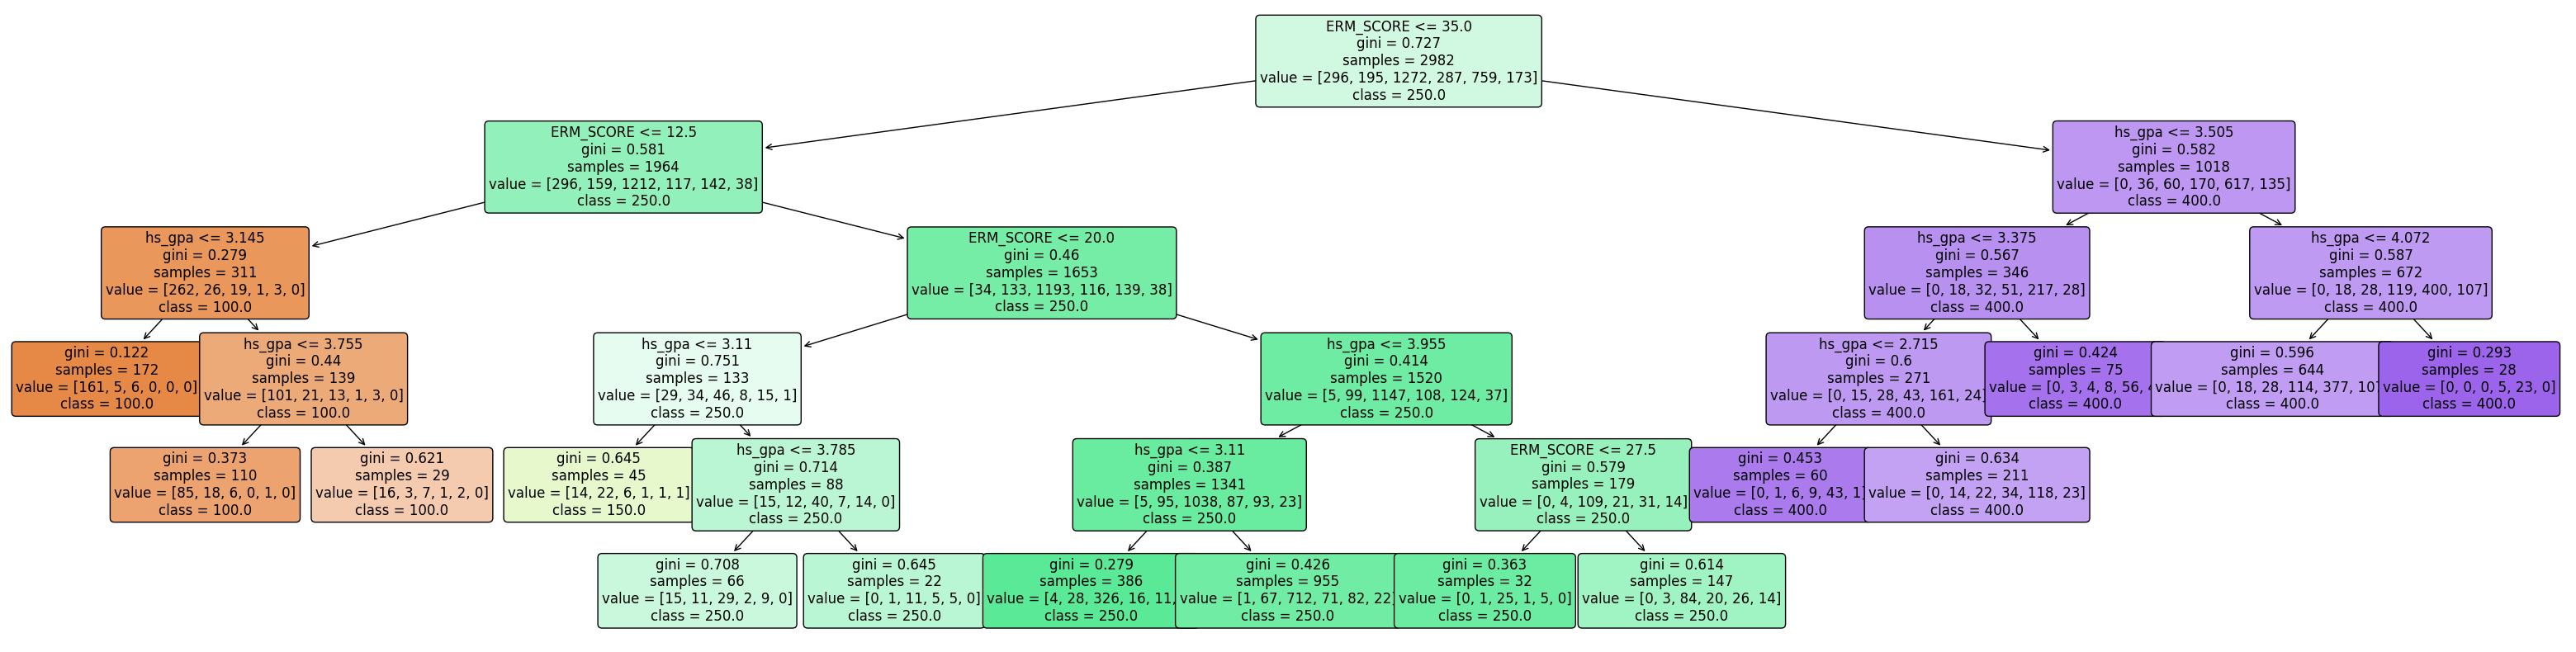

In [ ]:
# Visualize the decision tree
plt.figure(figsize=(40,10))
plot_tree(clf_course_number, 
          feature_names=X_train.columns, 
          class_names=course_number_encoder.classes_.astype(str),  # Ensure class names are string
          filled=True, rounded=True, 
          fontsize=12)


# Display the figure
plt.show()

## Model 5: XG Boost

In [ ]:

#Encode the target variable
course_number_encoder = LabelEncoder()
df_merged['course_level_encoded'] = course_number_encoder.fit_transform(df_merged['course_level'])

#Prepare the data
X = df_merged[['ERM_SCORE', 'hs_gpa']]
y = df_merged['course_level_encoded'] 

# Ensure no NaN values in predictors
X = X.dropna()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Continue with initializing and fitting your XGBoost classifier
xgb_model_course_number = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model_course_number.fit(X_train, y_train)

# Predict on the test data
y_pred_course_number = xgb_model_course_number.predict(X_test)

# Decode the predicted course numbers back to the original course numbers for interpretability
predicted_course_numbers = course_number_encoder.inverse_transform(y_pred_course_number)

# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred_course_number)  # This comparison should now be valid
print(f'Accuracy of the XGBoost model for course number prediction: {accuracy:.2f}')


Accuracy of the XGBoost model for course number prediction: 0.68



Classification Report:
              precision    recall  f1-score   support

       100.0       0.84      0.84      0.84        81
       250.0       0.15      0.05      0.07        60
       300.0       0.73      0.90      0.81       359
       400.0       0.23      0.04      0.06        83
       150.0       0.62      0.83      0.71       220
       500.0       0.00      0.00      0.00        49

    accuracy                           0.68       852
   macro avg       0.43      0.44      0.42       852
weighted avg       0.58      0.68      0.61       852



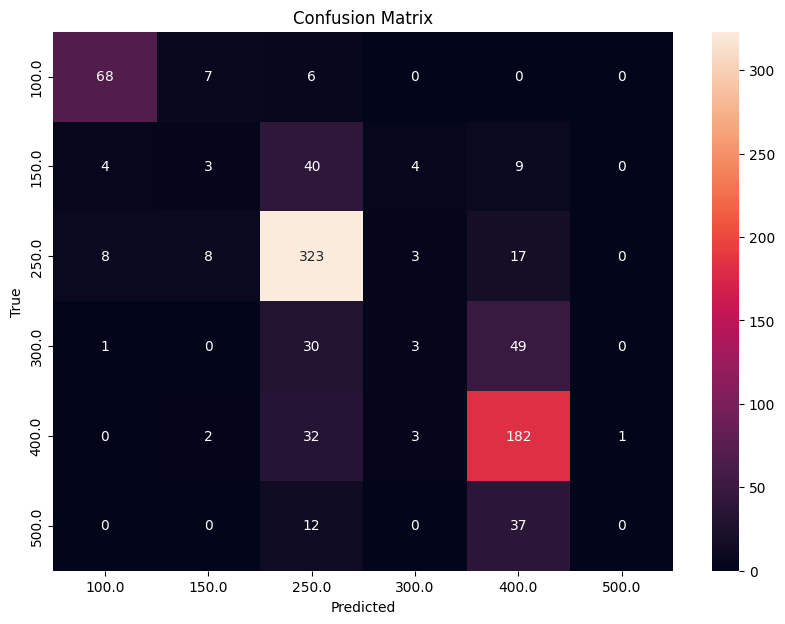

In [ ]:
# Convert the unique encoded labels back to original string labels
# Ensure original_class_labels are strings
original_class_labels_str = [str(label) for label in course_number_encoder.inverse_transform(df_merged['course_level_encoded'].unique())]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_course_number, target_names=original_class_labels_str))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_course_number)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=course_number_encoder.classes_, yticklabels=course_number_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## UNUSED CODE

In [ ]:

# Removing rows with NA in 'hs_gpa' or 'ERM_SCORE' columns before any processing
df_merged.dropna(subset=['hs_gpa', 'ERM_SCORE'], inplace=True)

# Prepare the incoming_students DataFrame by explicitly creating it or filtering df_merged
incoming_students = df_merged.copy()

# Define the list of courses, including combinations as tuples
included_courses = [
    '088', '105Q', '090', '216Q', '132', '121Q', '161Q', '151Q', '165Q', '171Q',
    ('005', '105Q'), ('063', '090'), ('021', '121Q')
]

# Initialize a dictionary to store each course's LabelEncoder and model
model_info = {}

for course in included_courses:
    # Filter the DataFrame for the current course or combination
    if isinstance(course, tuple):
        df_filtered = df_merged[df_merged['course_number'].isin(course)]
    else:
        df_filtered = df_merged[df_merged['course_number'] == course]

    # Continue only if there are records after filtering
    if not df_filtered.empty:
        X = df_filtered[['hs_gpa', 'ERM_SCORE']]
        y = df_filtered['grade_category']

        # Encoding the target variable for the current course
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        # Train the logistic regression model
        log_reg = LogisticRegression(max_iter=1000)
        log_reg.fit(X, y_encoded)

        # Store the trained model and its label encoder in the dictionary
        model_info[course] = {'model': log_reg, 'encoder': label_encoder}

# Placeholder DataFrame for storing predictions
predictions = pd.DataFrame(index=incoming_students.index)

# Iterating over the models to predict outcomes for incoming students
for course, info in model_info.items():
    model = info['model']
    encoder = info['encoder']
    
    # Predicting with the model
    pred_encoded = model.predict(incoming_students[['hs_gpa', 'ERM_SCORE']])

    # Inversely transforming encoded predictions into original labels
    pred_decoded = encoder.inverse_transform(pred_encoded)

    # Storing predictions in the DataFrame under the course name or combination
    course_key = '&'.join(course) if isinstance(course, tuple) else course
    predictions[course_key] = pred_decoded

# Defining a function to determine the highest-level course for which a student is predicted to be successful
def determine_highest_level(row):
    # Example logic for determining the highest-level course
    # You may need to adapt this based on your course hierarchy and success criteria
    for course in reversed(included_courses):
        course_key = '&'.join(course) if isinstance(course, tuple) else course
        if row.get(course_key) == 'Successful':
            return course_key
    return 'None'

# Apply the function to each row in predictions DataFrame
predictions['Highest_Level_Course'] = predictions.apply(determine_highest_level, axis=1)

output_file = 'Predictions.csv'

# Join df_merged with predictions using an appropriate method, e.g., merge, join, concat
# Ensure the join keys or indexes align properly between df_merged and predictions
# For simplicity, I'll assume df_merged and predictions can be directly concatenated
# You may need to adjust based on your actual DataFrame structures
df_merged_with_predictions = pd.concat([df_merged, predictions], axis=1)

# Save the merged dataframe to a CSV file
df_merged_with_predictions.to_csv(output_file, index=False)

print(f"Predictions saved to '{output_file}'.")


Predictions saved to 'Predictions.csv'.
